In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import fileread as fr
from scipy.signal import fftconvolve
import predefined as pd
import wave_ops as wo
from scipy import signal

def wave(t,*pars):
    amp,t0,tau1,tau2=pars
    return np.heaviside(t-t0,1.)*amp*(np.exp(-(t-t0).astype(float)/tau1)-np.exp(-(t-t0).astype(float)/tau2))

def gen_synth_pulse(amp, T0, length, wf):
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant
    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2)
    cur_s=np.zeros(2);cur_f=np.zeros(2)
    cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf;

def linearCombine(a,b,c,t0):# (N,*pars):
    N=3500
    t=np.arange(N,dtype=float)
    v=np.zeros((7,N)) #np.zeros((len(pars),N))
    t=np.arange(N,dtype=float)
    w=2*np.pi/3500.
    v[0,0:N]=a1*np.sin(w*t)
    v[1,0:N]=b1*np.cos(w*t)
    #v[2,0:N]=a2*np.sin(w/2.*t)
    #v[3,0:N]=b2*np.cos(w/2.*t)
    v[4,0:N]=gen_synth_pulse(c,t0,N,v[4,0:N])
    #v[4,0:N]=c*wave(t,1,t0,tau,rise)
    return np.sum(v,axis=0)
means=np.array([1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000, 1230.2096, 1188.8999,\
                1000, 1263.1642, 1233.1743, 1056.3289, 1213.4717, 1112.0769, 1049.4534, 1219.0482,\
                1000, 1000, 1077.4932, 1157.1627, 1000, 1163.2235, 1000, 1000,\
                1000, 1027.103, 1111.1212, 1033.5468, 1109.469, 1022.693, 1929.7336, 1000,\
                1000, 1124.478, 1073.1306, 1040.2197, 1100.4457, 1045.0566, 1135.8975, 1073.1854,\
                1000, 1000, 1087.187, 1133.1069, 1005.3494, 1000, 1000, 1000])
means=np.ones(48,dtype='float')*1250
def ols(data):
    length=len(data['wave'][0])
    rise,top=20,0
    shorttraps=np.zeros((48,length))
    wo.multi_trap(arr=shorttraps,rise=20,top=1)
    pars=np.zeros((len(data),4+3+1+1)) #2 osc amps, 1 pulse amp +t0, 3 amp uncertainties,x^2,sigma
    DesignT=np.array([linearCombine(0,0)])
    SSE=0
    for i in range(len(data)):
        bd,ch=data['board'][i],data['channel'][i]
        bdch=8*bd+ch
        loc=np.argmax(signal.fftconvolve(data['wave'][i],shorttraps[bdch], \
                            'full')[0:length]/float(rise*means[bdch]))-rise
        DesignT[0,0:length]=linearCombine(1,loc-5)
        pars[i,3]=np.matmul(np.matmul(np.linalg.inv(np.matmul(DesignT,DesignT.T)),\
                        DesignT),data['wave'][i])
        ehat=data['wave'][i]-np.matmul(DesignT.T,pars[i,3:4])
        pars[i,4]=loc
        SSE=np.matmul(ehat.T,ehat)/(length-1)  ##### MINUS NUMBER OF FITTED PARS
        pars[i,6]=np.sqrt(np.diag(np.linalg.inv(np.matmul(DesignT,DesignT.T)))*SSE)[0]
        pars[i,7]=SSE
        pars[i,8]=SSE*length
    return pars

run='/home/noah/Desktop/large_analysis/ca_analysis/Run_131_0.bin'
run='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/Run_0_0.bin'
numwaves=int((os.stat(run).st_size-8)/7033)
data=fr.raw(run,length=3500,row=1000,numwaves=10000)
wo.baseline_restore(data,600)
pars= ols(data[0:10000])

[37.73565699 36.35401628 36.75596795 ... 38.2762538  37.37550688
 37.99138077]


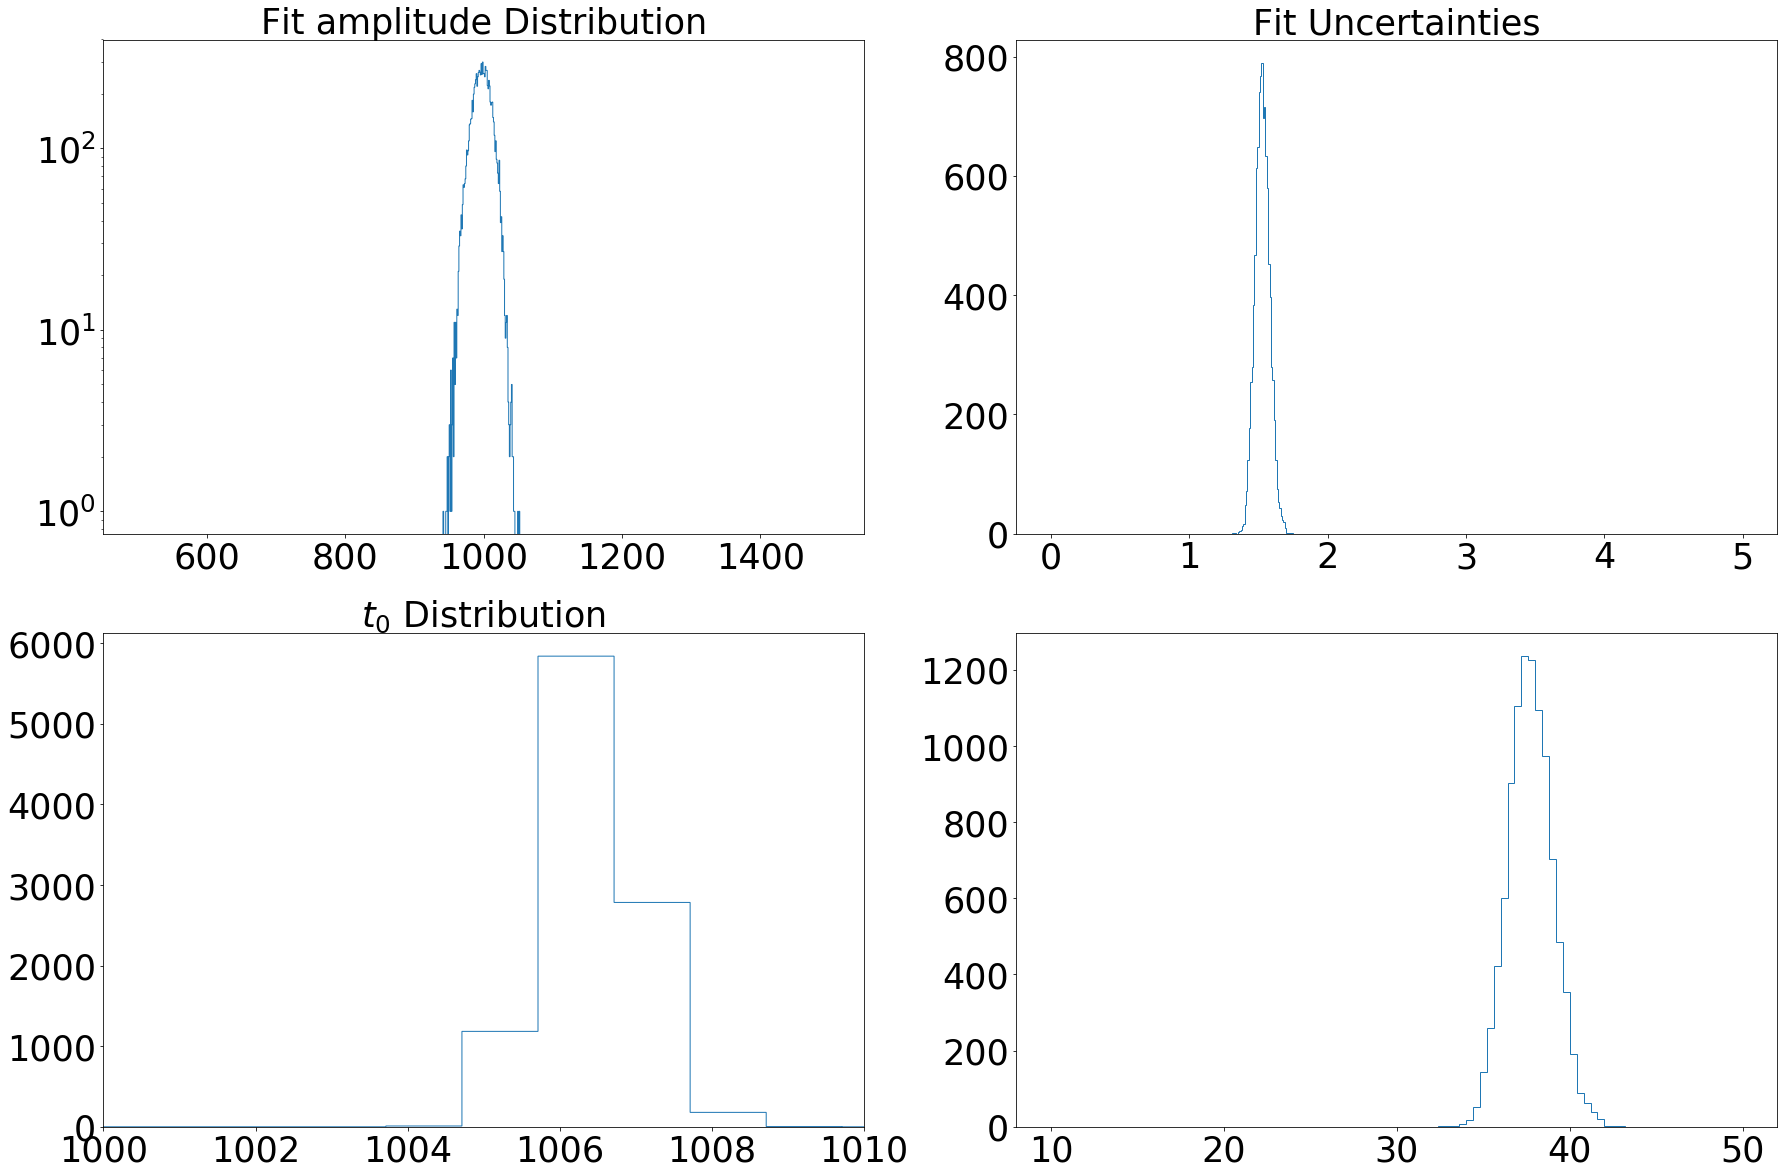

In [3]:
# fs=35
# print(np.sqrt(pars[:,7]))
# fig,ax=plt.subplots(2, 2,figsize=(30,20))
# ax[0,0].set_title('Fit amplitude Distribution',fontsize=fs)
# ax[0,0].hist(pars[:,3],bins=1000,range=[500,1500],histtype='step',label='Ideal Function')
# ax[0,1].set_title('Fit Uncertainties',fontsize=fs)
# ax[0,1].hist(pars[:,6],bins=500,range=[0,5],histtype='step',label='Ideal Function')
# ax[1,0].set_title(r'$t_0$ Distribution',fontsize=fs)
# ax[1,0].hist(pars[:,4],bins=3500,range=[0,3499],histtype='step',label='Ideal Function')
# ax[1,0].set_xlim((1000,1010))
# ax[1,1].hist(np.sqrt(pars[:,7]),bins=100,range=[10,50],histtype='step',label='Ideal Func')
# ax[0,0].set_yscale('log')
# for item in ax.flatten():
#     item.tick_params(labelsize=fs)
# plt.show()